import necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense


Load the stock data:

In [2]:
# You can use any source to get the stock data, for example, Yahoo Finance
# Here, I'm using the yfinance library to get the data
!pip install yfinance
import yfinance as yf

# Load historical stock data for Apple Inc.
symbol = "AAPL"
start_date = "2010-01-01"
end_date = "2022-01-01"
data = yf.download(symbol, start=start_date, end=end_date)

# Use the closing prices for prediction
df = data['Close'].to_frame()


[*********************100%%**********************]  1 of 1 completed


Preprocess the data:

In [3]:
# Normalize the data using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Split the data into training and testing sets
train_size = int(len(df_scaled) * 0.8)
test_size = len(df_scaled) - train_size
train_data, test_data = df_scaled[0:train_size, :], df_scaled[train_size:len(df_scaled), :]


Create the LSTM model:

In [4]:
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Reshape the data to fit the LSTM model input shape
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Create the LSTM model
model = create_lstm_model((x_train.shape[1], 1))


Train the LSTM model:

In [5]:
model.fit(x_train, y_train, epochs=10, batch_size=1)


Epoch 1/10
2356/2356 [==============================] - 84s 34ms/step - loss: 1.1395e-04
Epoch 2/10
2356/2356 [==============================] - 84s 36ms/step - loss: 5.1490e-05
Epoch 3/10
2356/2356 [==============================] - 78s 33ms/step - loss: 4.3765e-05
Epoch 4/10
2356/2356 [==============================] - 78s 33ms/step - loss: 3.0382e-05
Epoch 5/10
2356/2356 [==============================] - 80s 34ms/step - loss: 2.9289e-05
Epoch 6/10
2356/2356 [==============================] - 80s 34ms/step - loss: 2.7376e-05
Epoch 7/10
2356/2356 [==============================] - 79s 33ms/step - loss: 2.2982e-05
Epoch 8/10
2356/2356 [==============================] - 78s 33ms/step - loss: 2.2074e-05
Epoch 9/10
2356/2356 [==============================] - 78s 33ms/step - loss: 1.9130e-05
Epoch 10/10
2356/2356 [==============================] - 79s 34ms/step - loss: 1.8383e-05


Test the model:

In [6]:
# Prepare the test data
inputs = df[len(df) - len(test_data) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

x_test = []
for i in range(60, len(inputs)):
    x_test.append(inputs[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Make predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(df[-len(test_data):].values, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


19/19 [==============================] - 5s 39ms/step
Root Mean Squared Error (RMSE): 3.4236629193346046


Visualize the results:

<ipython-input-7-55894d9abbf4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


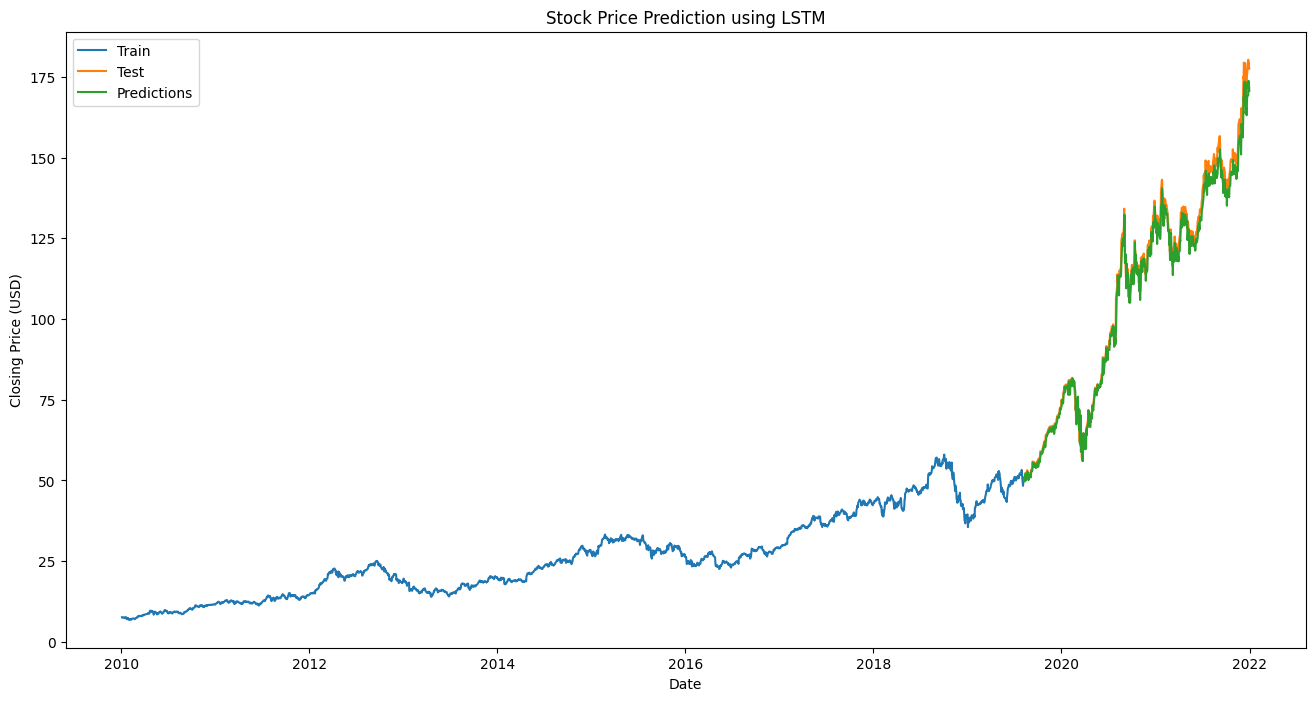

In [7]:
# Plot the actual vs. predicted stock prices
train = df[:train_size]
test = df[train_size:]
test['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.plot(train['Close'])
plt.plot(test[['Close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='upper left')
plt.show()
